In [1]:
%%capture
from datetime import datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
from sklearn import metrics
plt.rcParams.update({"font.size": 12})
%matplotlib inline

In [2]:
wsb_common_users_data = pd.read_csv("data/WSB_data_with_emb.csv",sep=';', usecols = ['title'], low_memory = True)
stocks_common_users_data= pd.read_csv("stocks/data/stocks_submissions_all.csv",sep=';', usecols = ['title'], low_memory = True)
investing_common_users_data= pd.read_csv("investing/data/investing_submissions_all.csv",sep=';', usecols = ['title'], low_memory = True)

In [3]:
# Create new column denoting class label and combine into one df
wsb_common_users_data['sub'] = 'wsb'
stocks_common_users_data['sub'] = 'stocks'
investing_common_users_data['sub'] = 'investing'

In [4]:
stocks_common_users_data.head(1)

,title,sub
0,SNAP seems like a great long-term buy at this ...,stocks


In [5]:
investing_common_users_data.head(1)

,title,sub
0,What do you use to invest?,investing


In [6]:
all_data = wsb_common_users_data.append(investing_common_users_data, ignore_index=True)

In [7]:
all_data = all_data.append(stocks_common_users_data, ignore_index=True)

In [8]:
all_data = all_data[pd.notnull(all_data['title'])]

In [9]:
all_data.head(1)

,title,sub
0,BB,wsb


In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144025 entries, 0 to 1144026
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1144025 non-null  object
 1   sub     1144025 non-null  object
dtypes: object(2)
memory usage: 26.2+ MB


In [11]:
all_data['sub_id'] = all_data['sub'].factorize()[0]
category_id_df = all_data[['sub', 'sub_id']].drop_duplicates().sort_values('sub_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sub_id', 'sub']].values)
all_data.head()

,title,sub,sub_id
0,BB,wsb,0
1,Surely it is a coincidence.,wsb,0
2,yolo sava options,wsb,0
3,meme,wsb,0
4,BB,wsb,0


In [12]:
sample_data_1=all_data[all_data['sub']=='wsb'].sample(frac = 0.025)

In [13]:
sample_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21544 entries, 44878 to 198268
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21544 non-null  object
 1   sub     21544 non-null  object
 2   sub_id  21544 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 673.2+ KB


In [14]:
sample_data_2=all_data[all_data['sub']=='stocks'].sample(frac = 0.15)

In [15]:
sample_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23176 entries, 1088343 to 1143802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23176 non-null  object
 1   sub     23176 non-null  object
 2   sub_id  23176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 724.2+ KB


In [16]:
sample_data_3=all_data[all_data['sub']=='investing'].sample(frac = 0.15)

In [17]:
sample_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23176 entries, 1088343 to 1143802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23176 non-null  object
 1   sub     23176 non-null  object
 2   sub_id  23176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 724.2+ KB


In [61]:
sample_data = sample_data_1.append(sample_data_2, ignore_index=True)
sample_data = sample_data.append(sample_data_3, ignore_index=True)
sample_data = sample_data[pd.notnull(sample_data['title'])]

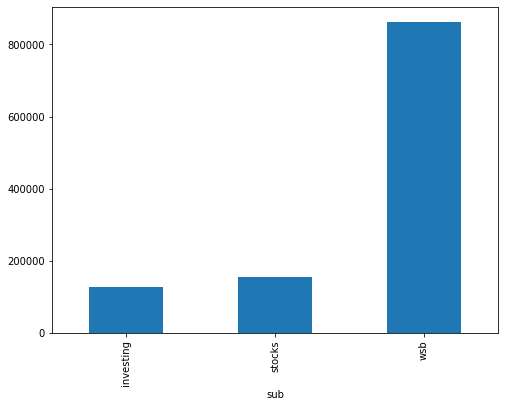

In [62]:
fig = plt.figure(figsize=(8,6))
all_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

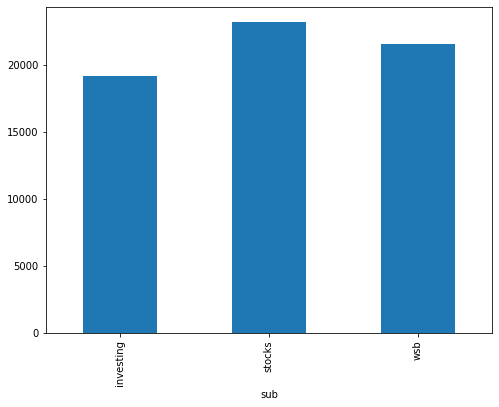

In [63]:
fig = plt.figure(figsize=(8,6))
sample_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

In [64]:
import re
re.sub('[^A-Za-z0-9]+','', 'What do you use to invest?🚀🚀🚀')

'Whatdoyouusetoinvest'

In [65]:
import string

'What. wsb do$ you stocks use/  r/stocks to investing wallstreetbets?🚀🚀🚀'.lower().translate(str.maketrans('', '', string.punctuation)).replace("wsb", "").replace("stocks", "").replace("wallstreetbets", "").replace("investing", "")

'what  do you  use  r to  🚀🚀🚀'

In [67]:
#clean titles to remove special characters, 'wsb','stocks','investing','wallstreetbets'
sample_data['title'] = sample_data['title'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)).replace("wsb", "").replace("stocks", "").replace("wallstreetbets", "").replace("investing", "") )


In [68]:
sample_data['title'][:5]

0                                 amc is it the bottom
1                 crsr update the pirates want tendies
2    there is information that the crying kitten bu...
3                                mark cuban approves 🚀
4      what is now banned at rh in germany is all open
Name: title, dtype: object

In [69]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 1), stop_words='english',token_pattern=r'[^\s]+')
features = tfidf.fit_transform(sample_data.title).toarray() #+all_data.selftext
labels = sample_data.sub_id
features.shape

(63885, 6920)

In [70]:
N = 15
for Product, category_id in sorted(category_to_id.items()):
   # X{array-like, sparse matrix} of shape (n_samples, n_features)
    #y -array-like of shape (n_samples,)
    #Target vector (class labels).
  features_chi2 = chi2(features, labels == category_id) 

  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
 

# 'investing':
  . Most correlated unigrams:
. vanguard
. funds
. 401k
. mutual
. bonds
. index
. questions
. fund
. moon
. roth
. amc
. ira
. gme
. investment
. invest
# 'stocks':
  . Most correlated unigrams:
. new
. fucking
. tendies
. amc
. apes
. fuck
. 🚀🚀🚀
. retards
. question
. trading
. yolo
. moon
. gme
. thoughts
. stock
# 'wsb':
  . Most correlated unigrams:
. fucking
. question
. fuck
. retards
. 🚀
. stock
. apes
. hold
. bb
. invest
. 🚀🚀🚀
. yolo
. amc
. moon
. gme


In [72]:
X_train, X_test, y_train, y_test = train_test_split(sample_data['title'], sample_data['sub'], random_state = 0)
count_vect = CountVectorizer(token_pattern=r'[^\s]+')#analyzer = 'char', binary = True)
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [73]:
print(clf.predict(count_vect.transform(["🦍"])))

['wsb']


In [74]:
print(clf.predict(count_vect.transform(["🚀"])))

['wsb']


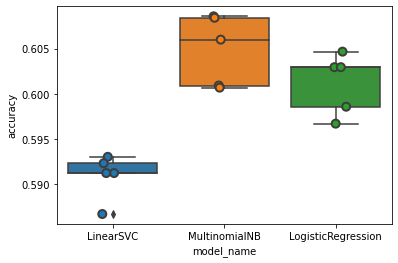

In [75]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0,max_iter=3000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [76]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.590890
LogisticRegression    0.601174
MultinomialNB         0.604931
Name: accuracy, dtype: float64

In [77]:
category_id_df['sub'].values

array(['wsb', 'investing', 'stocks'], dtype=object)

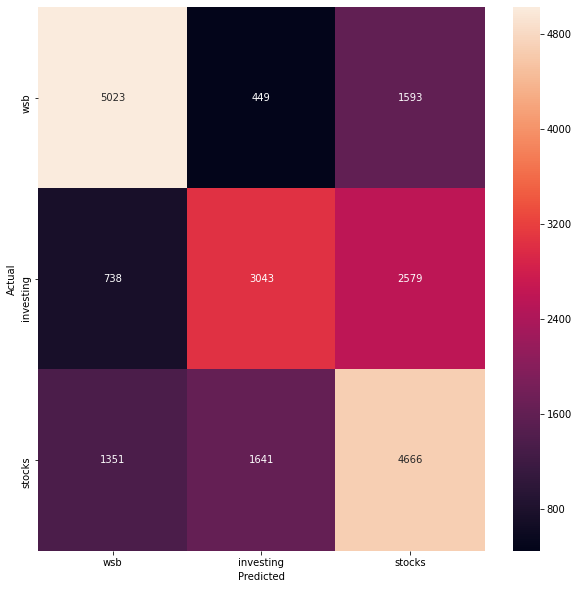

In [78]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['sub'].values, yticklabels=category_id_df['sub'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [79]:
category_id_df

,sub,sub_id
0,wsb,0
861752,investing,1
989521,stocks,2


In [80]:
from IPython.display import display
for predicted in category_id_df.sub_id:
  for actual in category_id_df.sub_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(sample_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['sub', 'title']])
      print('')

'investing' predicted as 'wsb' : 738 examples.


,sub,title
49551,investing,wow someone who isnt appalled by dave portnoy
52552,investing,“ elys gaming “
62755,investing,robinhood sent a margin account of 200000 to m...
48676,investing,if you had to short something what would it be...
61921,investing,this stock is a goldmine literally
...,...,...
46108,investing,how can shares shorted exceed the float ie mor...
49541,investing,skill or luck
46446,investing,completely forgot i had signed up for etoros c...
60193,investing,the bang rally was a pump and dump scheme by h...



'stocks' predicted as 'wsb' : 1351 examples.


,sub,title
23900,stocks,blackrock inc has officially hit the bottom of...
26987,stocks,charlie munger calls robinhood a ‘gambling par...
26880,stocks,holding onto 100 shares of bynd that i picked ...
39561,stocks,what should i buy tommorow
26852,stocks,limit order cancellation
...,...,...
22342,stocks,is it “wrong” to short
33828,stocks,sold cci this morning but balance available fo...
35198,stocks,hedge fund shit
32505,stocks,morning update for monday 062121



'wsb' predicted as 'investing' : 449 examples.


,sub,title
14513,wsb,i wrote a script that tracks the day’s highest...
9836,wsb,its for your own protection
14487,wsb,sse crashed on cv news peaked twice during ful...
12114,wsb,the wallstreet bets network
12711,wsb,community game using marketwatchs virtual sto...
...,...,...
10195,wsb,longshort signals for popular stonks
10166,wsb,teslas stock will be added to the sampp 500 in...
20702,wsb,dipping my toes into
12913,wsb,75k to 1k witness me some questionable trades ...



'stocks' predicted as 'investing' : 1641 examples.


,sub,title
24007,stocks,what is the best way to invest 1600 into a rot...
23864,stocks,19 year old advice
29853,stocks,grab on netflix now
30481,stocks,genuine question regarding cryptocurrency
39839,stocks,windfall lump sum average or sell and reinvest
...,...,...
32931,stocks,sndl very exciting setup
28707,stocks,4000 per person to travel in the us a new bill...
36022,stocks,any good books for better understanding a comp...
42488,stocks,brokerage recommendation



'wsb' predicted as 'stocks' : 1593 examples.


,sub,title
7757,wsb,pltr is tracking spy today
10918,wsb,bynd will it drop on the 29th
6651,wsb,futu and gbs volatile buy
6289,wsb,how it started
11706,wsb,game on
...,...,...
12779,wsb,prostitution
6122,wsb,massively undervalued container tonnage provid...
19074,wsb,long on ostk amp tls
10645,wsb,tlry board continues support of merger with ap...



'investing' predicted as 'stocks' : 2579 examples.


,sub,title
62178,investing,why is teva stock doing so well
45041,investing,please review my portfolio
45721,investing,what will be a trigger for you to get out of a...
49636,investing,sos stock
59771,investing,thoughts on nok
...,...,...
50897,investing,brkab unaffected
53083,investing,asml stock is up 32 in the last 6 months
63239,investing,good to be alive
46221,investing,soinflation huh…what now


In [81]:
model.fit(features, labels)


MultinomialNB()

In [90]:
N = 50
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]

  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       {}".format(', '.join(unigrams)))
  

# 'investing':
  . Top unigrams:
       invest, stock, market, investment, question, advice, portfolio, help, buy, best, good, new, money, trading, vs, etf, funds, thoughts, etfs, looking, ira, does, fund, time, long, options, questions, index, term, account, roth, need, companies, start, investor, buying, just, company, investors, year, like, think, crypto, short, shares, cash, value, sell, price, robinhood
# 'stocks':
  . Top unigrams:
       stock, buy, thoughts, market, new, trading, question, good, invest, help, advice, best, today, portfolio, sell, looking, long, buying, time, term, going, need, options, think, does, short, tesla, price, gme, just, earnings, company, shares, investment, vs, money, robinhood, amc, day, free, 2021, etf, start, etfs, amp, like, week, use, know, companies
# 'wsb':
  . Top unigrams:
       gme, amc, moon, hold, buy, robinhood, just, like, stock, yolo, bb, going, short, today, holding, 🚀, time, 🚀🚀🚀, im, market, nok, sell, apes, right, i’m, new, fuck, c

In [83]:
print(metrics.classification_report(y_test, y_pred, target_names=sample_data['sub'].unique()))

              precision    recall  f1-score   support

         wsb       0.71      0.71      0.71      7065
      stocks       0.59      0.48      0.53      6360
   investing       0.53      0.61      0.57      7658

    accuracy                           0.60     21083
   macro avg       0.61      0.60      0.60     21083
weighted avg       0.61      0.60      0.60     21083



# 'investing':
(0, ('\U0001f9a7', -10.747524048494917))
(1, ('mobility', -10.747524048494917))
(2, ('mobil', -10.747524048494917))
(3, ('moass', -10.747524048494917))
(4, ('mnmd', -10.747524048494917))
(5, ('mms', -10.747524048494917))
(6, ('mmat', -10.747524048494917))
(7, ('mm', -10.747524048494917))
(8, ('boyfriends', -10.747524048494917))
(9, ('mjna', -10.747524048494917))
(10, ('boyz', -10.747524048494917))
(11, ('bp', -10.747524048494917))
(12, ('brained', -10.747524048494917))
(13, ('brains', -10.747524048494917))
(14, ('brave', -10.747524048494917))
(15, ('surely', -10.747524048494917))
(16, ('surf', -10.747524048494917))
(17, ('misinformation', -10.747524048494917))
(18, ('mins', -10.747524048494917))
(19, ('breakfast', -10.747524048494917))
(20, ('mini', -10.747524048494917))
(21, ('milk', -10.747524048494917))
(22, ('breath', -10.747524048494917))
(23, ('brethren', -10.747524048494917))
(24, ('brew', -10.747524048494917))


C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 129447 missing from current font.
  font.set_text(s, 0, flags=flags)


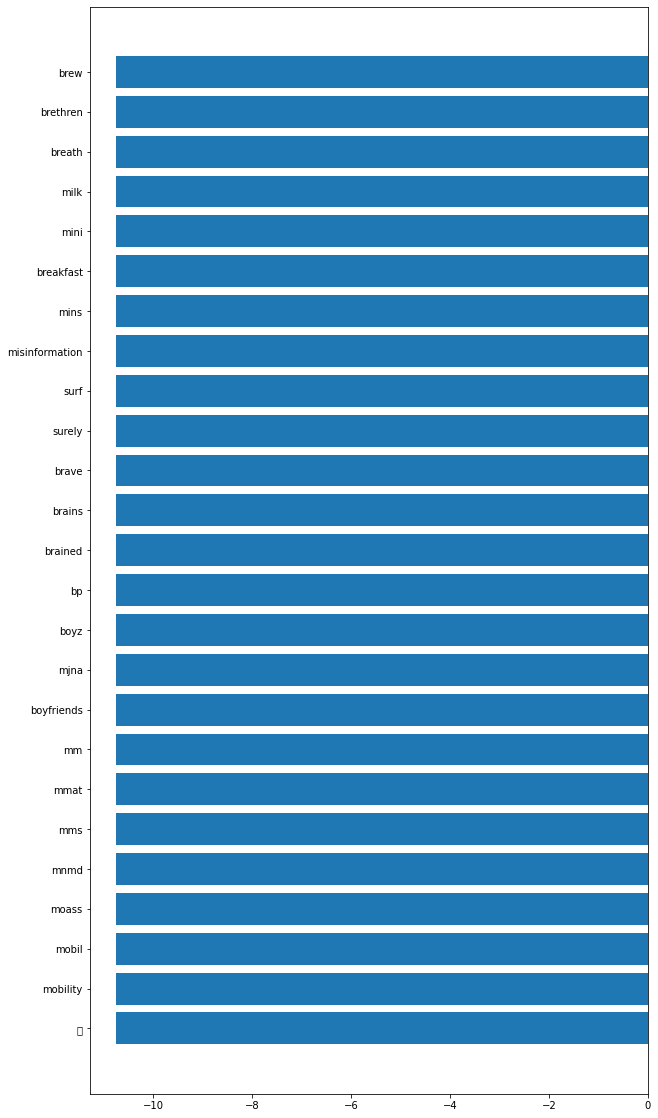

# 'stocks':
(0, ('\U0001f9a7', -10.831497099136689))
(1, ('countrys', -10.831497099136689))
(2, ('street’s', -10.831497099136689))
(3, ('strap', -10.831497099136689))
(4, ('crayon', -10.831497099136689))
(5, ('stolen', -10.831497099136689))
(6, ('crime', -10.831497099136689))
(7, ('crowdfunding', -10.831497099136689))
(8, ('cruz', -10.831497099136689))
(9, ('stfu', -10.831497099136689))
(10, ('cryptocurrencies', -10.831497099136689))
(11, ('cuck', -10.831497099136689))
(12, ('cucked', -10.831497099136689))
(13, ('cucks', -10.831497099136689))
(14, ('cum', -10.831497099136689))
(15, ('stayed', -10.831497099136689))
(16, ('cute', -10.831497099136689))
(17, ('cuz', -10.831497099136689))
(18, ('station', -10.831497099136689))
(19, ('starring', -10.831497099136689))
(20, ('dare', -10.831497099136689))
(21, ('darkness', -10.831497099136689))
(22, ('staring', -10.831497099136689))
(23, ('daughter', -10.831497099136689))
(24, ('dawn', -10.831497099136689))


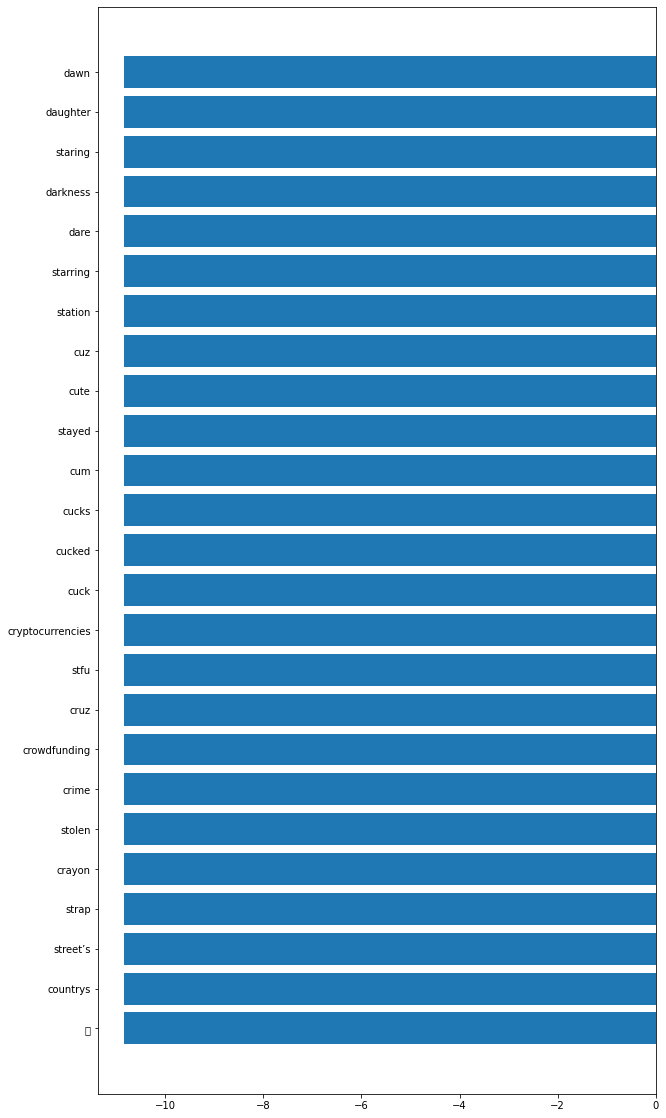

# 'wsb':
(0, ('caribbean', -10.806979571053768))
(1, ('horizons', -10.806979571053768))
(2, ('horizon', -10.806979571053768))
(3, ('homework', -10.806979571053768))
(4, ('homes', -10.806979571053768))
(5, ('transparent', -10.806979571053768))
(6, ('transportation', -10.806979571053768))
(7, ('revolutionary', -10.806979571053768))
(8, ('statements', -10.806979571053768))
(9, ('vt', -10.806979571053768))
(10, ('annualized', -10.806979571053768))
(11, ('annuity', -10.806979571053768))
(12, ('seed', -10.806979571053768))
(13, ('hindsight', -10.806979571053768))
(14, ('hims', -10.806979571053768))
(15, ('sedg', -10.806979571053768))
(16, ('rick', -10.806979571053768))
(17, ('anticipating', -10.806979571053768))
(18, ('antidumping', -10.806979571053768))
(19, ('vryyf', -10.806979571053768))
(20, ('trit', -10.806979571053768))
(21, ('crispr', -10.806979571053768))
(22, ('hostile', -10.806979571053768))
(23, ('criteria', -10.806979571053768))
(24, ('trailing', -10.806979571053768))


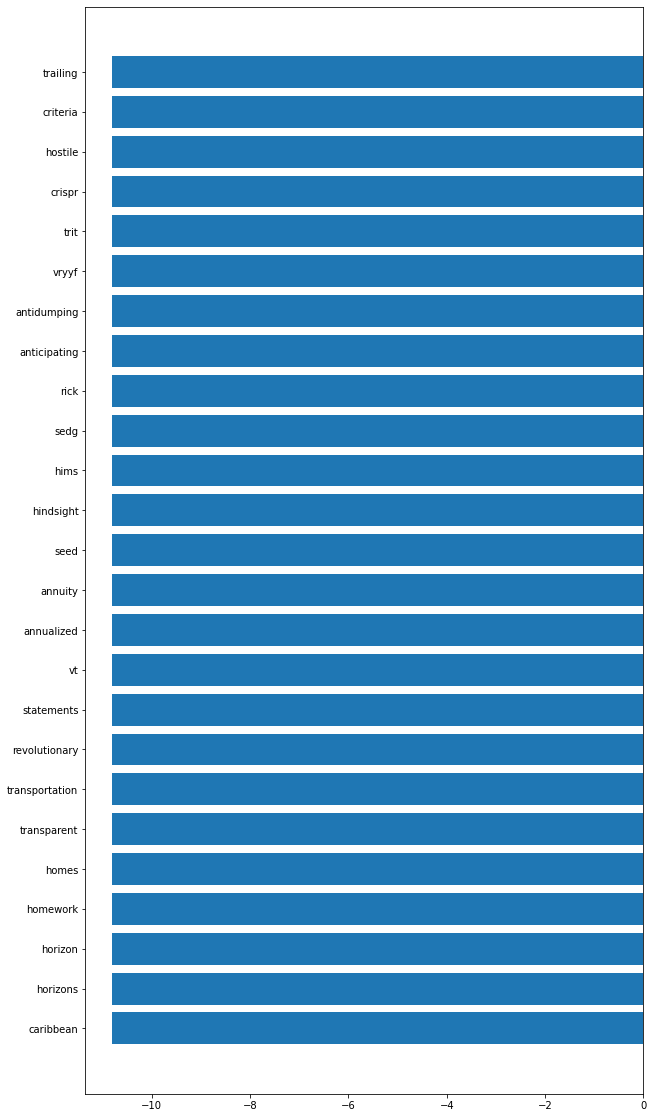

In [84]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[:25],importance[:25])):
        print((i,v))
    # plot feature importance
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[:25], importance[:25])    
    pyplot.show()

# 'investing':
(0, ('robinhood', -6.275536791220668))
(1, ('price', -6.259393629163196))
(2, ('sell', -6.257950638191942))
(3, ('value', -6.244376253707492))
(4, ('cash', -6.233251212324569))
(5, ('shares', -6.222216171173681))
(6, ('short', -6.22078055560165))
(7, ('crypto', -6.2159457975894705))
(8, ('think', -6.213260688072614))
(9, ('like', -6.211171841243385))
(10, ('year', -6.2060979501908236))
(11, ('investors', -6.2042284576809115))
(12, ('company', -6.151778064853554))
(13, ('just', -6.151413040935695))
(14, ('buying', -6.129436804912592))
(15, ('investor', -6.109598099289279))
(16, ('start', -6.073880482621268))
(17, ('companies', -6.044065959428392))
(18, ('need', -6.039986958689124))
(19, ('roth', -6.036071560878954))
(20, ('account', -6.0321594117903725))
(21, ('term', -6.03130482565352))
(22, ('index', -6.0001931874306145))
(23, ('questions', -5.998627662910208))
(24, ('options', -5.968210016253697))
(25, ('long', -5.9490506890045785))
(26, ('time', -5.93929854242785))
(2

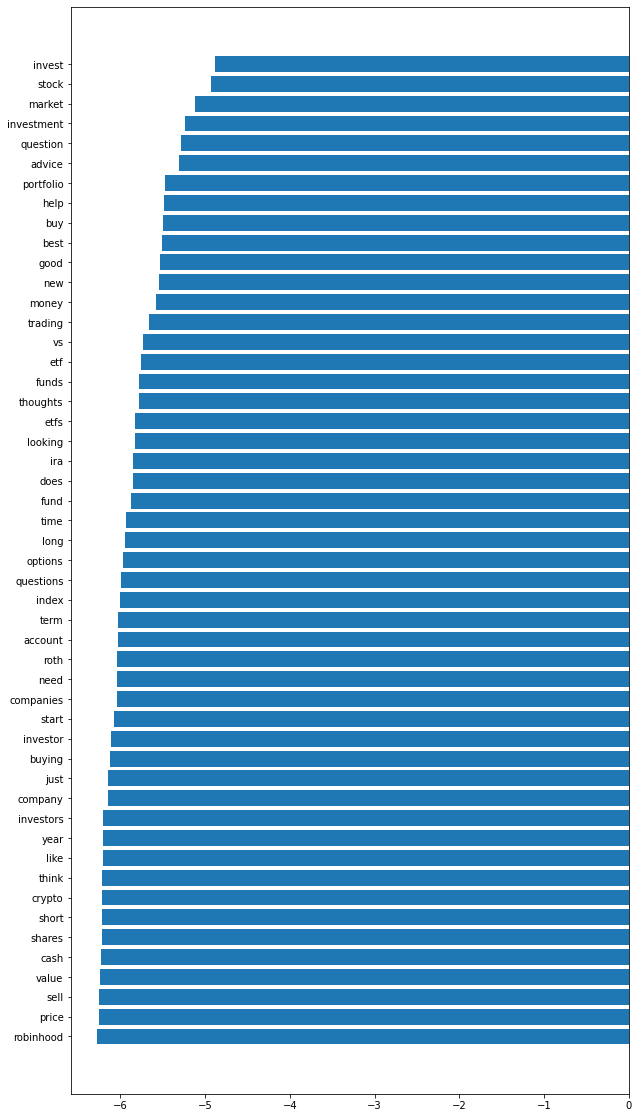

# 'stocks':
(0, ('companies', -6.275768941067118))
(1, ('know', -6.271861660355956))
(2, ('use', -6.2697992325713985))
(3, ('week', -6.269403645738627))
(4, ('like', -6.227926481428505))
(5, ('amp', -6.216301475468634))
(6, ('etfs', -6.185356467094203))
(7, ('start', -6.179369645998885))
(8, ('etf', -6.176588412273402))
(9, ('2021', -6.172795293042716))
(10, ('free', -6.141605335759226))
(11, ('day', -6.122283724697095))
(12, ('amc', -6.11052948044974))
(13, ('robinhood', -6.109677003954146))
(14, ('money', -6.0739108900270224))
(15, ('vs', -6.047452001625887))
(16, ('investment', -6.0457139333149525))
(17, ('shares', -6.0308601896050895))
(18, ('company', -6.029819878522383))
(19, ('earnings', -6.019429153391136))
(20, ('just', -5.997953065529613))
(21, ('gme', -5.971683398854867))
(22, ('price', -5.952157811047053))
(23, ('tesla', -5.932643452221242))
(24, ('short', -5.925503350684387))
(25, ('does', -5.893436205241191))
(26, ('think', -5.888438885851112))
(27, ('options', -5.8762076

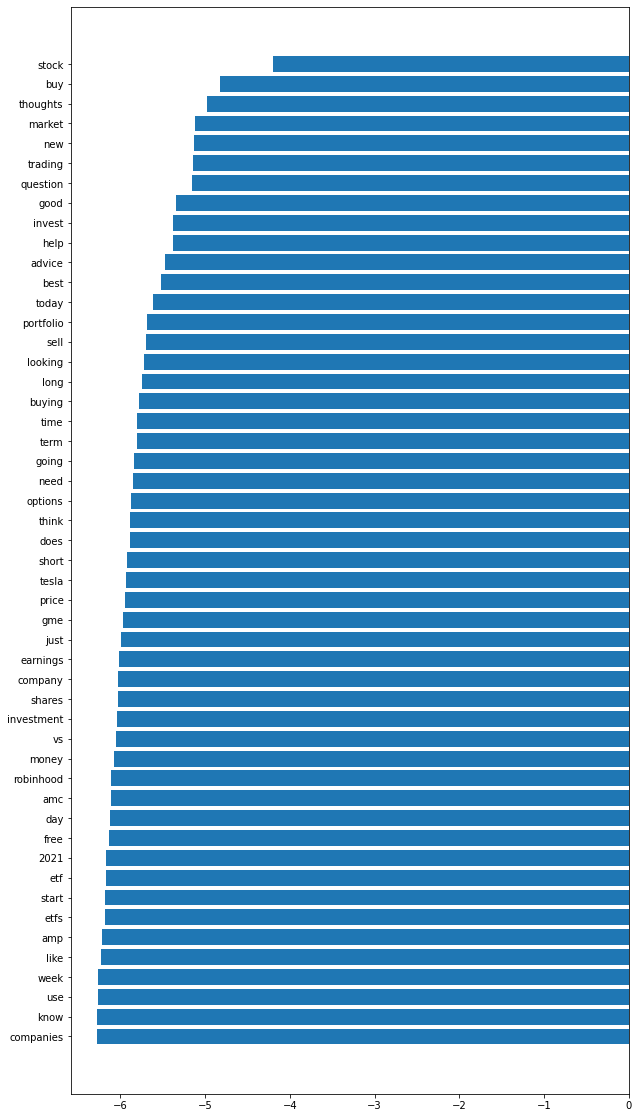

# 'wsb':
(0, ('it’s', -6.2252027100382135))
(1, ('good', -6.206546962419671))
(2, ('dont', -6.197824175425689))
(3, ('know', -6.192647531670054))
(4, ('puts', -6.189831071542105))
(5, ('make', -6.189074675115439))
(6, ('retards', -6.179655662734173))
(7, ('trading', -6.174985729179601))
(8, ('fucking', -6.165336493701708))
(9, ('tomorrow', -6.153958112162183))
(10, ('lets', -6.149796633491896))
(11, ('got', -6.139369009835651))
(12, ('think', -6.137829265287655))
(13, ('day', -6.129950718000879))
(14, ('doing', -6.129475293719672))
(15, ('did', -6.122135250753932))
(16, ('week', -6.110703511595588))
(17, ('squeeze', -6.105404030846947))
(18, ('guys', -6.0902094273186504))
(19, ('money', -6.061579486458294))
(20, ('shares', -6.023868687296341))
(21, ('bought', -5.993381901974262))
(22, ('calls', -5.9919919961798795))
(23, ('fuck', -5.988153109805555))
(24, ('new', -5.978987978511527))
(25, ('i’m', -5.975702883055175))
(26, ('right', -5.971152697307626))
(27, ('apes', -5.960670175053979)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0, flags=flags)


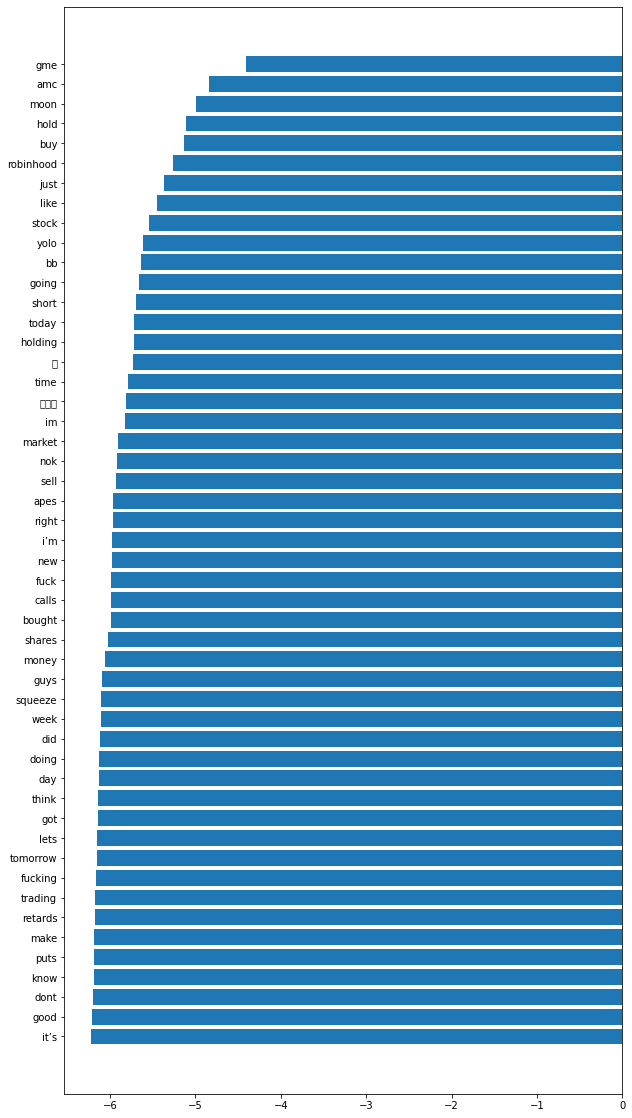

In [85]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-50):],importance[(len(feature_names[:])-50):])):
        print((i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[len(feature_names[:])-50:], importance[len(feature_names[:])-50:])    
    pyplot.show()

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


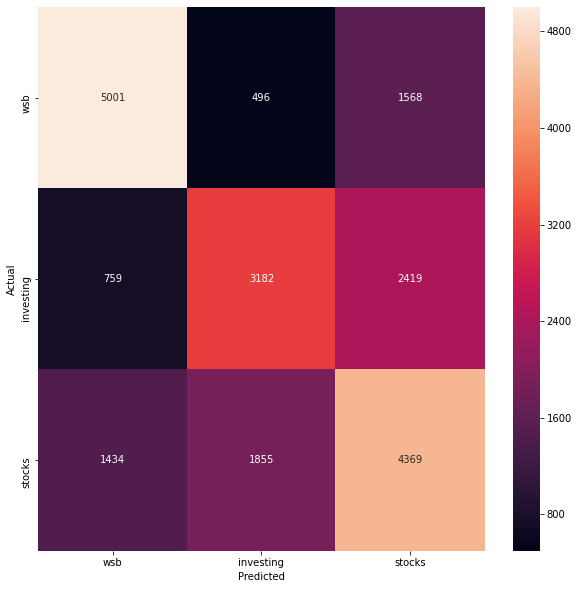

In [91]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['sub'].values, yticklabels=category_id_df['sub'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [92]:
model.fit(features, labels)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [93]:
N = 50
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]

  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       {}".format(', '.join(unigrams)))
  

# 'investing':
  . Top unigrams:
       spitballin, bonds, estate, invest, crypto, ira, bitcoin, business, 401k, investment, etfs, loans, asset, retirement, assets, acorns, crowdfunding, bond, earn, questions, vanguard, startups, private, housing, gdp, equity, cryptocurrency, property, investments, buffett, intelligent, hsa, basic, 2018, compound, resident, investor, countries, fund, economy, etf, online, giveaway, registration, japanese, moronic, dca, yield, cryptocurrencies, reinvest
# 'stocks':
  . Top unigrams:
       dgly, stock, shll, dkng, term, se, airlines, watchlist, etfs, enph, workhorse, utility, pink, gnus, plug, sqqq, mgm, codx, metaverse, thursday, r, alpp, dividend, recap, taper, mrna, 1600, etsy, therapeutics, bp, stoploss, corporation, salesforce, mojo, logistics, mro, fiasco, shopify, sq, question, synopsis, scyx, ties, jun, thoughts, dodge, sava, poised, tsx, depot
# 'wsb':
  . Top unigrams:
       yolo, retards, retard, tendies, autist, autists, porn, 💎🙌, retarded,

In [94]:
print(metrics.classification_report(y_test, y_pred, target_names=sample_data['sub'].unique()))

              precision    recall  f1-score   support

         wsb       0.70      0.71      0.70      7065
      stocks       0.58      0.50      0.54      6360
   investing       0.52      0.57      0.55      7658

    accuracy                           0.60     21083
   macro avg       0.60      0.59      0.59     21083
weighted avg       0.60      0.60      0.59     21083



# 'investing':
(0, ('reinvest', 1.4896490225616468))
(1, ('cryptocurrencies', 1.489965447932738))
(2, ('yield', 1.4960450833763197))
(3, ('dca', 1.5011056822801314))
(4, ('moronic', 1.509537189852371))
(5, ('japanese', 1.5112730486063137))
(6, ('registration', 1.5118372907107156))
(7, ('giveaway', 1.5314541396425043))
(8, ('online', 1.5322207578904816))
(9, ('etf', 1.5323637504843495))
(10, ('economy', 1.5341703629639039))
(11, ('fund', 1.5371614102851685))
(12, ('countries', 1.5562599855220463))
(13, ('investor', 1.5566867758387417))
(14, ('resident', 1.5575153827879062))
(15, ('compound', 1.5700832933729336))
(16, ('2018', 1.5725257048417913))
(17, ('basic', 1.5830058188160558))
(18, ('hsa', 1.5835811390264467))
(19, ('intelligent', 1.6139280629553856))
(20, ('buffett', 1.6168689107806524))
(21, ('investments', 1.6243982055934416))
(22, ('property', 1.6284321824092116))
(23, ('cryptocurrency', 1.6705638119772834))
(24, ('equity', 1.6736549812317443))
(25, ('gdp', 1.689474885968013))


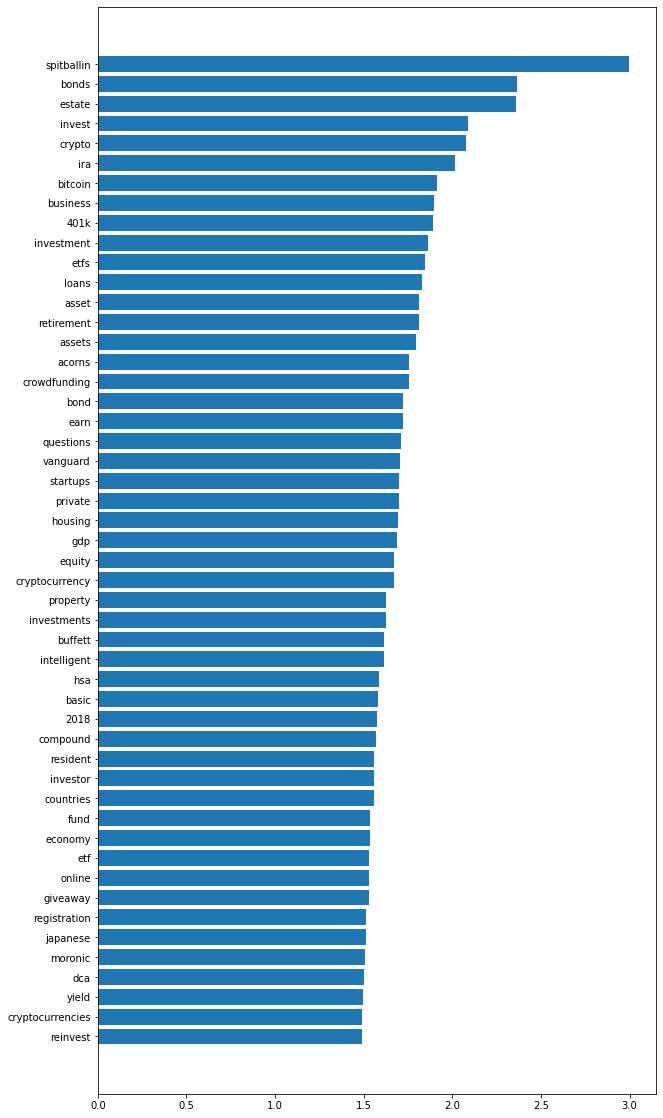

# 'stocks':
(0, ('depot', 1.1094306242443943))
(1, ('tsx', 1.1143229524334173))
(2, ('poised', 1.1304846681937435))
(3, ('sava', 1.1333010124529044))
(4, ('dodge', 1.1333300193462612))
(5, ('thoughts', 1.144897318419963))
(6, ('jun', 1.1468640419982585))
(7, ('ties', 1.1509768267152258))
(8, ('scyx', 1.1538943209430712))
(9, ('synopsis', 1.1588369143532282))
(10, ('question', 1.1763645516385808))
(11, ('sq', 1.1780257297371743))
(12, ('shopify', 1.1782701502146484))
(13, ('fiasco', 1.1803691150653106))
(14, ('mro', 1.1879111167591911))
(15, ('logistics', 1.1958914508188407))
(16, ('mojo', 1.2011235319054696))
(17, ('salesforce', 1.2054654224227666))
(18, ('corporation', 1.209686146980411))
(19, ('stoploss', 1.2206797794336142))
(20, ('bp', 1.2361446279704473))
(21, ('therapeutics', 1.2363541750233047))
(22, ('etsy', 1.2427841396000634))
(23, ('1600', 1.2457448013491437))
(24, ('mrna', 1.2529640880158075))
(25, ('taper', 1.2577628640170526))
(26, ('recap', 1.2583990772267777))
(27, ('di

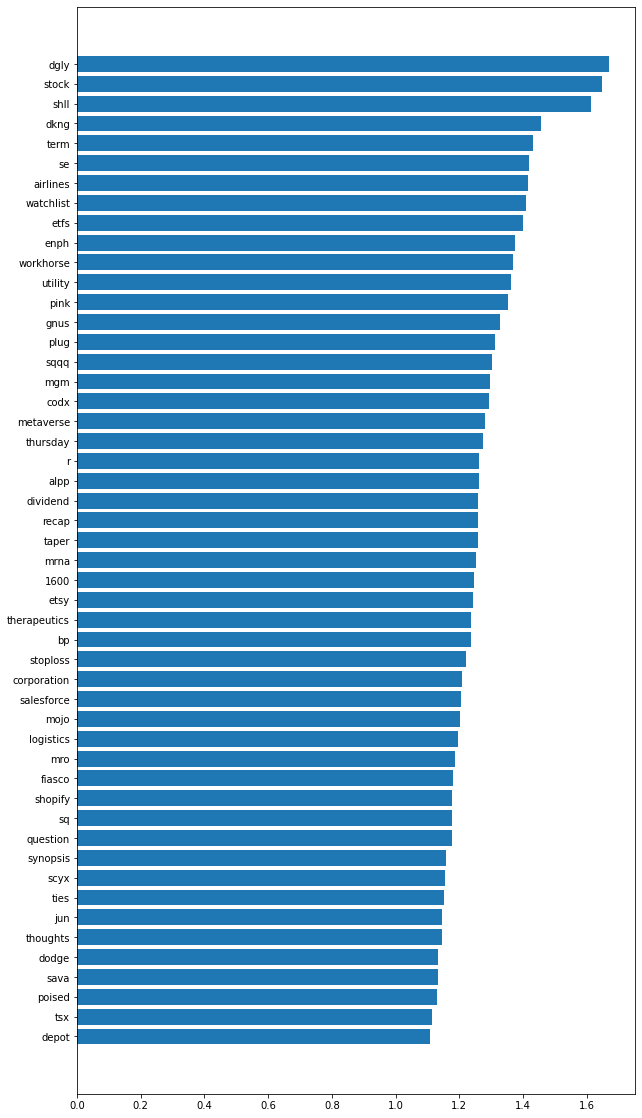

# 'wsb':
(0, ('em', 1.7828213008815605))
(1, ('hedgies', 1.7829618408944823))
(2, ('log', 1.7911127682691979))
(3, ('becky', 1.79734058330796))
(4, ('ill', 1.8057175507485181))
(5, ('hodl', 1.8072836910585601))
(6, ('we’re', 1.8152680986859036))
(7, ('69', 1.8260325483043562))
(8, ('bois', 1.8338419404416695))
(9, ('fuckers', 1.8466735218563606))
(10, ('shit', 1.8483322809402358))
(11, ('lmao', 1.859236529503867))
(12, ('stonk', 1.8789651597116215))
(13, ('jpow', 1.879395163821834))
(14, ('allowing', 1.881147718034342))
(15, ('blocking', 1.8931612840844751))
(16, ('hands', 1.9001640338876116))
(17, ('fucked', 1.9067937033976536))
(18, ('💎👐', 1.9164175651130757))
(19, ('yolod', 1.9276361942623428))
(20, ('memes', 1.9496218702539114))
(21, ('thanks', 1.9506461970496312))
(22, ('dfv', 1.9513680582207278))
(23, ('confirmed', 2.0049080061654174))
(24, ('degenerates', 2.021962835943594))
(25, ('papa', 2.036915561015157))
(26, ('clov', 2.044226955999547))
(27, ('autistic', 2.0724119690452705)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128059 missing from current font.
  font.set_text(s, 0.0, flags=flags)


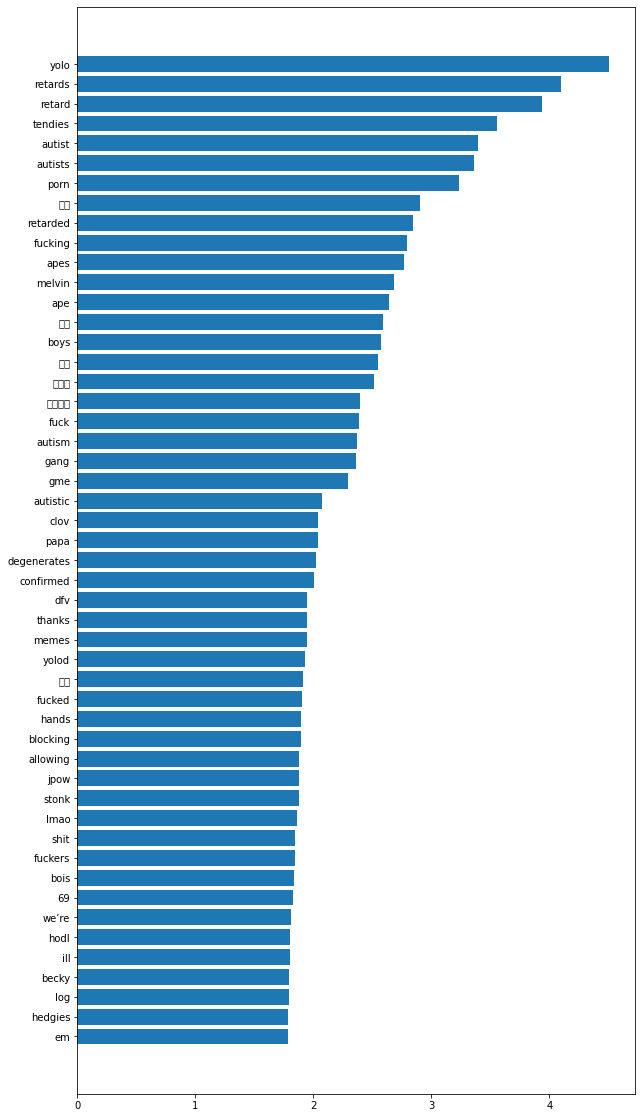

In [95]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-50):],importance[(len(feature_names[:])-50):])):
        print((i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[len(feature_names[:])-50:], importance[len(feature_names[:])-50:])    
    pyplot.show()

# 'investing':
(0, ('assets', 1.797530867652439))
(1, ('retirement', 1.8120913149159046))
(2, ('asset', 1.8132959365091161))
(3, ('loans', 1.8311402067140223))
(4, ('etfs', 1.8457571237170727))
(5, ('investment', 1.8638672763102393))
(6, ('401k', 1.890918603668992))
(7, ('business', 1.894990814274817))
(8, ('bitcoin', 1.9114535452211088))
(9, ('ira', 2.0149097402994864))
(10, ('crypto', 2.0768788360956445))
(11, ('invest', 2.091020624258631))
(12, ('estate', 2.3566096820396223))
(13, ('bonds', 2.3673649207332694))
(14, ('spitballin', 2.998290550503033))


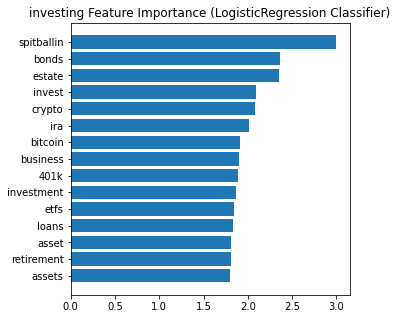

# 'stocks':
(0, ('plug', 1.313468074132993))
(1, ('gnus', 1.3278920590844556))
(2, ('pink', 1.351771713160826))
(3, ('utility', 1.3613429467707328))
(4, ('workhorse', 1.3699234600277683))
(5, ('enph', 1.3759467501289855))
(6, ('etfs', 1.3987468976215667))
(7, ('watchlist', 1.4100029993770806))
(8, ('airlines', 1.4145867959489895))
(9, ('se', 1.4177731369112885))
(10, ('term', 1.430976984900071))
(11, ('dkng', 1.4574905416722859))
(12, ('shll', 1.612833159569541))
(13, ('stock', 1.64856523555599))
(14, ('dgly', 1.6683370110791742))


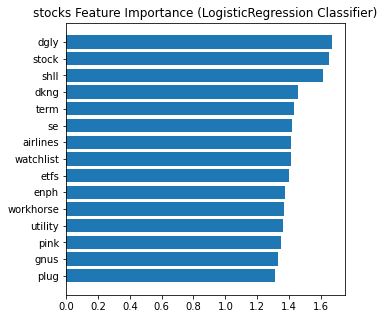

# 'wsb':
(0, ('boys', 2.5773550847907223))
(1, ('🚀🚀', 2.589543248118777))
(2, ('ape', 2.643203785384113))
(3, ('melvin', 2.6812211875758516))
(4, ('apes', 2.770288355470664))
(5, ('fucking', 2.792555049154752))
(6, ('retarded', 2.8460133346580947))
(7, ('💎🙌', 2.9076423936786626))
(8, ('porn', 3.2340006363517118))
(9, ('autists', 3.3628254452021946))
(10, ('autist', 3.396707803299572))
(11, ('tendies', 3.5594639535818318))
(12, ('retard', 3.937285761612039))
(13, ('retards', 4.096984816033226))
(14, ('yolo', 4.503537180248587))


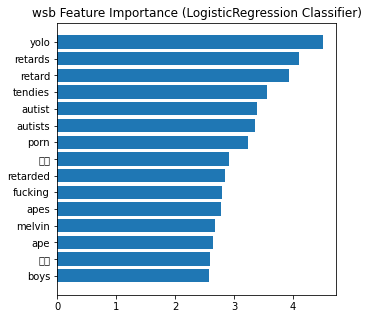

In [103]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-15):],importance[(len(feature_names[:])-15):])):
        print((i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(5,5))
    pyplot.barh(feature_names[len(feature_names[:])-15:], importance[len(feature_names[:])-15:])    
    pyplot.title(Product+" Feature Importance (LogisticRegression Classifier)")
    pyplot.show()